In [1]:
import os
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
# 01_single_image_test.ipynb

import numpy as np
import matplotlib.pyplot as plt

from src.config import *
from src.data_loader import load_nc_image, build_rgb_from_nc, load_mask
from src.ndvi_tools import select_best_ndvi_timestamp, compute_slic_superpixels
from src.sam_tools import load_sam_model, sam_predict_from_points, calculate_iou
from src.visualization import show_overlays


In [3]:
IMG_ID = "NL_1031"
img_path = os.path.join(IMAGES_DIR, f"{IMG_ID}.nc")
mask_path = os.path.join(MASKS_DIR, f"{IMG_ID}.tif")


In [4]:
ds = load_nc_image(img_path)
mask = load_mask(mask_path)

rgb = build_rgb_from_nc(ds)


In [5]:
# Step 1 — NDVI Timestamp Selection
ndvi_stack = ds["NDVI"].values.astype(np.float32)
best_t, stds = select_best_ndvi_timestamp(ndvi_stack)
print("Best timestamp:", best_t)

ndvi = ndvi_stack[best_t]
ndvi = np.nan_to_num(ndvi, nan=0.0)


Best timestamp: 2


In [6]:
seg = compute_slic_superpixels(ndvi, n_segments=70)

centroids = []
for label in np.unique(seg):
    ys, xs = np.where(seg == label)
    if len(xs) > 0:
        centroids.append([int(xs.mean()), int(ys.mean())])

print("Total centroids:", len(centroids))


Total centroids: 64


In [7]:
predictor = load_sam_model()

masks = sam_predict_from_points(
    predictor,
    rgb,
    centroids
)

# Merge all masks into one
fused = np.any(np.stack(masks), axis=0)


D:\segment-anything\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [8]:
iou = calculate_iou(fused, mask)
print("Single-image IoU:", iou)


Single-image IoU: 0.6226632348956922


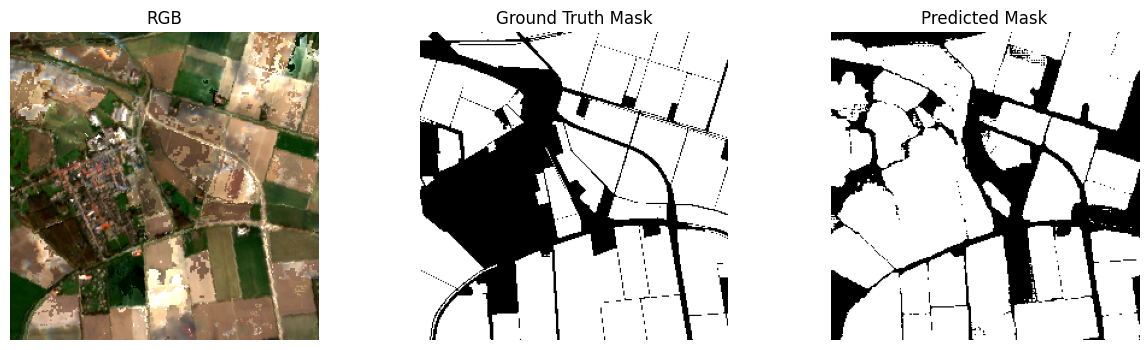

In [9]:
show_overlays(rgb, mask, fused)
